In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path as pt
from loguru import logger
from typing import TypedDict, Literal, Optional, List, Dict, Union
import json

In [13]:
root_loc = pt('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/')
base_loc = root_loc / 'ML properties/Analysed/[PHYSICAL CONSTANTS OF ORGANIC COMPOUNDS]/'

model = 'lgbm'
embeddings = 'mol2vec_embeddings'
method = 'Optuna'
pre_trained_filename = f'{model}_{embeddings}_pretrained_model_{method}'
loc = base_loc / f'tmp_C_processed_data/analysis_data/filtered/tmpC_topelements_processed_data/pretrained_models/{model}/{embeddings}/{method}/'

resultsfile = loc / f'{pre_trained_filename}.results.json'
datfile = loc / f'{pre_trained_filename}.dat.json'

print(f'resultsfile exists: {resultsfile.exists()}')
print(f'datfile exists: {datfile.exists()}')

resultsfile exists: True
datfile exists: True


In [27]:
# Define the structure of the inner dictionaries
class DataEntry(TypedDict):
    y_true: List[float]
    y_pred: List[float]
    y_linear_fit: List[float]
    
class DataType(TypedDict):
    test: DataEntry
    train: DataEntry


# Define the Embedding type
Embedding = Literal['mol2vec', 'VICGAE']

# Define the MLStats TypedDict
class MLStats(TypedDict):
    r2: float
    mse: float
    rmse: float
    mae: float

# Define the CVScores TypedDict
class CVScores(TypedDict):
    mean: float
    std: float
    ci_lower: float
    ci_upper: float
    scores: List[float]

# Define the CV_scoring_methods type
CV_scoring_methods = Literal['r2', 'mse', 'rmse', 'mae']

# Define the LearningCurveData type
LearningCurveData = Dict[str, Dict[Literal['test', 'train'], CVScores]]

# Define the CVScoresData type
CVScoresData = Dict[Literal['test', 'train'], Dict[CV_scoring_methods, CVScores]]

# Define the PlotData and Layout TypedDicts (assuming simplified structures)
class PlotData(TypedDict, total=False):
    x: List[float]
    y: List[float]
    type: str
    name: str

class Layout(TypedDict, total=False):
    title: str
    xaxis: Dict[str, Union[str, int, float]]
    yaxis: Dict[str, Union[str, int, float]]

# Define the MLResults TypedDict
class MLResults(TypedDict):
    learning_curve_plotly_data: Optional[Dict[str, Union[List[PlotData], Layout]]]
    embedding: Embedding
    PCA: bool
    data_shapes: Dict[str, List[int]]
    train_stats: MLStats
    test_stats: MLStats
    model: str
    bootstrap: bool
    bootstrap_nsamples: Optional[int]
    cross_validation: bool
    cv_fold: Optional[int]
    cv_scores: Optional[CVScoresData]
    best_params: Optional[Dict[str, Union[str, int, bool, None]]]
    best_score: Optional[float]
    timestamp: str
    time: str
    

In [28]:
results: MLResults = json.load(open(resultsfile, 'r'))
data: DataType = json.load(open(datfile, 'r'))

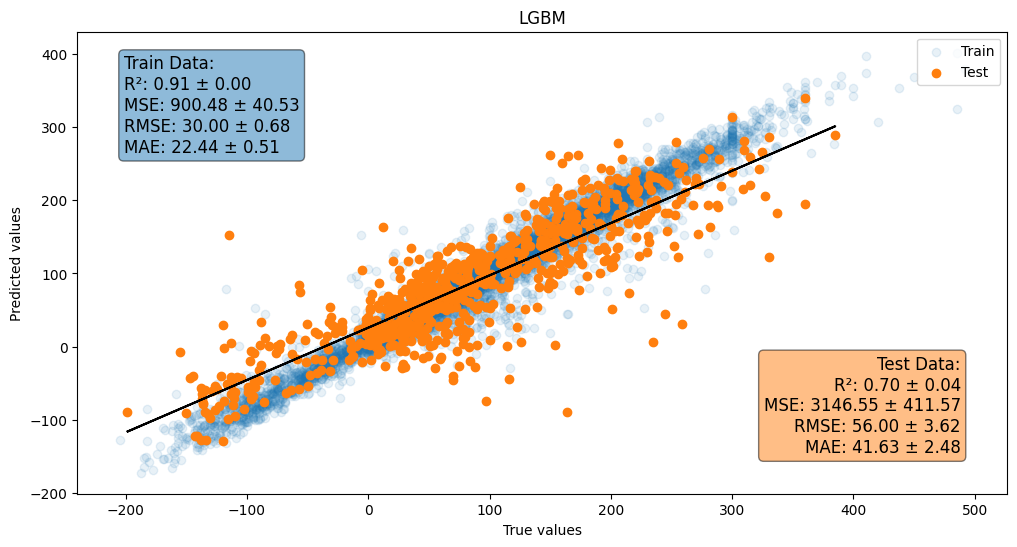

In [83]:
# plot the test and train data with scatter plot
# the fitted line is also plotted
# take rmse, r2, mae, mse from the results and plot them in the title (take it from cv_scores)

# get the data
y_true_test = data["test"]["y_true"]
y_pred_test = data["test"]["y_pred"]
y_linear_fit_test = data["test"]["y_linear_fit"]

y_true_train = data["train"]["y_true"]
y_pred_train = data["train"]["y_pred"]
y_linear_fit_train = data["train"]["y_linear_fit"]


metrics = ["r2", "mse", "rmse", "mae"]
test_scores = {}
train_scores = {}

for v in ["test", "train"]:
    for k in metrics:
        mean = results["cv_scores"][v][k]["mean"]
        std = results["cv_scores"][v][k]["std"]
        if v == "test":
            test_scores[k] = f"{mean:.2f} ± {std:.2f}"
        else:
            train_scores[k] = f"{mean:.2f} ± {std:.2f}"


fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(y_true_train, y_pred_train, color="C0", label="Train", alpha=0.1)
ax.scatter(y_true_test, y_pred_test, color="C1", label="Test")
ax.plot(y_true_test, y_linear_fit_test, color="k")
ax.set_xlabel("True values")
ax.set_ylabel("Predicted values")
ax.legend(loc='upper right')

# Add text annotations for metrics
textstr_train = "\n".join(
    (
        "Train Data:",
        f'R²: {train_scores["r2"]}',
        f'MSE: {train_scores["mse"]}',
        f'RMSE: {train_scores["rmse"]}',
        f'MAE: {train_scores["mae"]}',
    )
)

textstr_test = "\n".join(
    (
        "Test Data:",
        f'R²: {test_scores["r2"]}',
        f'MSE: {test_scores["mse"]}',
        f'RMSE: {test_scores["rmse"]}',
        f'MAE: {test_scores["mae"]}',
    )
)

ax.text(
    0.05,
    0.95,
    textstr_train,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="C0", alpha=0.5),
)
ax.text(
    0.95,
    0.30,
    textstr_test,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="C1", alpha=0.5),
)

ax.set_title(model.upper())
plt.show()


In [63]:
train_scores

{'r2': '0.91 ± 0.00',
 'mse': '900.48 ± 40.53',
 'rmse': '30.00 ± 0.68',
 'mae': '22.44 ± 0.51'}